# Duplicate detection - step 2: review and decide on candidate pairs

This notebook runs the second part of the duplicate detection algorithm on a dataframe with the following columns:

- `archiveType`       (used for duplicate detection algorithm)
- `dataSetName`
- `datasetId`
- `geo_meanElev`      (used for duplicate detection algorithm)
- `geo_meanLat`       (used for duplicate detection algorithm)
- `geo_meanLon`       (used for duplicate detection algorithm)
- `geo_siteName`      (used for duplicate detection algorithm)
- `interpretation_direction`
- `interpretation_seasonality`
- `interpretation_variable`
- `interpretation_variableDetails`
- `originalDataURL`
- `originalDatabase`
- `paleoData_notes`
- `paleoData_proxy`   (used for duplicate detection algorithm)
- `paleoData_units`
- `paleoData_values`  (used for duplicate detection algorithm, test for correlation, RMSE, correlation of 1st difference, RMSE of 1st difference)
- `paleoData_variableName`
- `year`              (used for duplicate detection algorithm)
- `yearUnits`

This interactive notebook runs a duplicate decision algorithm for a specific database, following the identification of the potential duplicate candidate pairs. The algorithm walks the operator through each of the detected duplicate candidate pairs from `dup_detection.ipynb` and runs a decision process to decide whether to keep or reject the identified records. 

The confirmed 'true' duplicates are saved in

`data/DATABASENAME/duplicate_detection/duplicate_decisions_DATABASENAME_AUTHORINITIALS_YY-MM-DD.csv`

10/11/2025 LL: tidied up with revised data organisation and prepared for documentation
27/11/2024 LL: Changed hierarchy FE23>PAGES 2k
22/10/2024 v1: Updated the decision process:
    - created backup decision file which is intermediately saved
    - outputs URL which can be copied and pasted into browser
    - implemented a composite option in the decision process, to create a composite of two records

Author: Lucie Luecke, created 27/9/2024



**Note**: The algorithm can be either started from scratch or from a backup file:


## Intialisation

### Set up working environment

Make sure the repo_root is added correctly, it should be: your_root_dir/dod2k
This should be the working directory throughout this notebook (and all other notebooks).

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
from pathlib import Path

# Add parent directory to path (works from any notebook in notebooks/)
# the repo_root should be the parent directory of the notebooks folder
current_dir = Path().resolve()
# Determine repo root
if current_dir.name == 'dod2k': repo_root = current_dir
elif current_dir.parent.name == 'dod2k': repo_root = current_dir.parent
else: raise Exception('Please review the repo root structure (see first cell).')

# Update cwd and path only if needed
if os.getcwd() != str(repo_root):
    os.chdir(repo_root)
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

print(f"Repo root: {repo_root}")
if str(os.getcwd())==str(repo_root):
    print(f"Working directory matches repo root. ")

Repo root: /home/jupyter-lluecke/dod2k_v2.0/dod2k
Working directory matches repo root. 


In [2]:
import pandas as pd
import numpy as np
import datetime

from dod2k_utilities import ut_functions as utf # contains utility functions
from dod2k_utilities import ut_duplicate_search as dup # contains utility functions

### Load dataset

Define the dataset which needs to be screened for duplicates. Input files for the duplicate detection mechanism need to be compact dataframes (`pandas` dataframes with standardised columns and entry formatting). 

The function `load_compact_dataframe_from_csv` loads the dataframe from a `csv` file from `data\DB\`, with `DB` the name of the database. The database name (`db_name`) can be 
- `pages2k`
- `ch2k`
- `iso2k`
- `sisal`
- `fe23`

for the individual databases, 

or use 

- `all_merged`

to load the merged database of all individual databases, or can be any user defined compact dataframe.

In [3]:
# load dataframe
db_name='all_merged' 
# db_name='ch2k' 
df = utf.load_compact_dataframe_from_csv(db_name)

print(df.info())
df.name = db_name


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5320 entries, 0 to 5319
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   archiveType                    5320 non-null   object 
 1   dataSetName                    5320 non-null   object 
 2   datasetId                      5320 non-null   object 
 3   geo_meanElev                   5221 non-null   float32
 4   geo_meanLat                    5320 non-null   float32
 5   geo_meanLon                    5320 non-null   float32
 6   geo_siteName                   5320 non-null   object 
 7   interpretation_direction       5320 non-null   object 
 8   interpretation_seasonality     5320 non-null   object 
 9   interpretation_variable        5320 non-null   object 
 10  interpretation_variableDetail  5320 non-null   object 
 11  originalDataURL                5320 non-null   object 
 12  originalDatabase               5320 non-null   o

### Input operator's credentials

In order to keep maximum transparency and reproduceability, put in the operator's credentials here.

These details are used to flag the intermediate output files and provided along with the final duplicate free dataset.


In [4]:
#initials = 'LL'
#fullname = 'Lucie Luecke'
#email    = 'ljluec1@st-andrews.ac.uk'
#operator_details = [initials, fullname, email]
initials = 'MNE'
fullname = 'Michael Evans'
email    = 'mnevans@umd.edu'
operator_details = [initials, fullname, email]

## Duplicate decision process

We now start the duplicate decision process.

### Hierarchy for duplicate removal for identical duplicates

For automated decisions, which apply to *identical* duplicates, we now define a hierarchy of databases, which decides which record should be kept.

First, list all the original databases:

In [5]:
for db in df.originalDatabase.unique():
    print(db)

PAGES 2k v2.2.0
FE23 (Breitenmoser et al. (2014))
CoralHydro2k v1.0.1
Iso2k v1.1.2
SISAL v3


Now assign a hierarchy to the original databases, from 1 the highest value (should always be kept) to the lowest value $n$ (the number of original databases)

In [6]:
# implement hierarchy for automated decisions for identical records

df['Hierarchy'] = 0 
df.loc[df['originalDatabase']=='PAGES2k v2.2.0', 'Hierarchy'] = 5
df.loc[df['originalDatabase']=='FE23 (Breitenmoser et al. (2014))', 'Hierarchy'] = 4
df.loc[df['originalDatabase']=='CoralHydro2k v1.0.1', 'Hierarchy'] = 2
df.loc[df['originalDatabase']=='Iso2k v1.1.2', 'Hierarchy'] = 3
df.loc[df['originalDatabase']=='SISAL v3', 'Hierarchy'] = 1

### Duplicate decision process

The following cell takes you through the potential duplicate candidate pairs and lets you decide whether to 
- keep both records
- keep just one record
- delete both records
- create composite of both records.

Recollections and updates of duplicates are automatically selected, as well as identical duplicates following the hierarchy defined above. 

The output is saved in `data/DB/dup_detection/dup_decisions_dod2k_dupfree_INITIALS_DATE.csv`

Summary figures are saved in `figs/DB/dup_detection/`, also linked in the output csv file.


**Note**: The operator has the option to restart the decision process from a backup file in the directory `data/DB/dup_detection`. This can be especially useful should the connection be interrupted during the process. 

Found backup file (data/all_merged/dup_detection/dup_decisions_all_merged_MNE_BACKUP.csv). Do you want to start decision process from the backup file? [y/n] y


header [' Decisions for duplicate candidate pairs. ', ' Operated by Michael Evans (MNE)', ' E-Mail: mnevans@umd.edu', ' Created on: 2025-11-26 11:57:27.730048 (UTC)', 'index 1']
data [['0', '4408', 'no figure', 'pages2k_0', 'iso2k_296', 'PAGES 2k v2.2.0', 'Iso2k v1.1.2', 'WDC05A', 'WDC05A', '-79.45999908447266', '-79.45999908447266', '-112.08999633789062', '-112.08999633789062', '1806.0', '1806.0', 'GlacierIce', 'GlacierIce', 'd18O', 'd18O', 'http://dx.doi.org/10.7265/N5QJ7F8B', 'https://www.ncdc.noaa.gov/paleo/study/22531', '786.0-2005.0', '786.0-2005.0', 'REMOVE', 'KEEP', 'AUTO: IDENTICAL except for URLs and/or geo_siteName.', 'RECORDS IDENTICAL (perfect correlation) except for metadata. Automatically choose #2.'], ['0', '4409', 'no figure', 'pages2k_0', 'iso2k_298', 'PAGES 2k v2.2.0', 'Iso2k v1.1.2', 'WDC05A', 'WDC05A', '-79.45999908447266', '-79.45999908447266', '-112.08999633789062', '-112.08999633789062', '1806.0', '1806.0', 'GlacierIce', 'GlacierIce', 'd18O', 'd18O', 'http://dx.

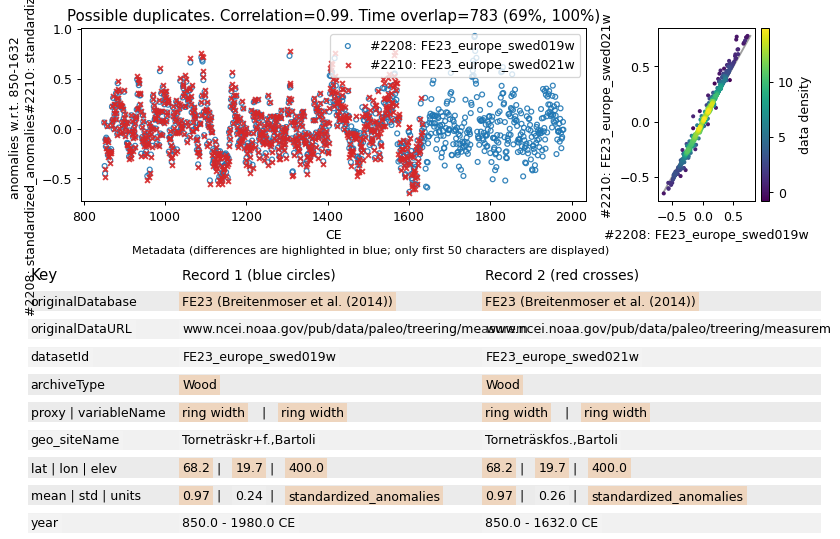

**Decision required for this duplicate pair (see figure above).**
Before inputting your decision. Would you like to leave a comment on your decision process?


 Please type your comment here and/or press enter. make composite of "fos" and "r+f" records from same location
Keep record 1 (FE23_europe_swed019w, blue circles) [1], record 2 (FE23_europe_swed021w, red crosses) [2], keep both [b], keep none [n] or create a composite of both records [c]?  [Type 1/2/b/n/c]: c


saved figure in /home/jupyter-lluecke/dod2k_v2.0/dod2k/figs//dup_detection/all_merged/283_FE23_europe_swed019w_FE23_europe_swed021w__2208_2210.jpg
CREATE A COMPOSITE OF BOTH RECORDS: FE23_europe_swed019w, FE23_europe_swed021w.
write decision to backup file
2388 2389 277 284
> 285/429,FE23_northamerica_mexico_mexi022,FE23_northamerica_mexico_mexi023,0.0,0.9705431503944612
=== POTENTIAL DUPLICATE 284/429: FE23_northamerica_mexico_mexi022+FE23_northamerica_mexico_mexi023 ===
=== URL 1: https://www.ncei.noaa.gov/pub/data/paleo/treering/measurements/northamerica/mexico/mexi022-noaa.rwl   ===
=== URL 2: https://www.ncei.noaa.gov/pub/data/paleo/treering/measurements/northamerica/mexico/mexi023-noaa.rwl   ===
True if pot_dup_corrs[i_pot_dups]>=0.98 else False False
(len(time_1)==len(time_2)) False
metadata_identical:  True
lat True lon True elevation True archivetype True paleodata_proxy True
sites_identical:  False
URL_identical:  False
data_identical:  False
correlation_perfect:  False


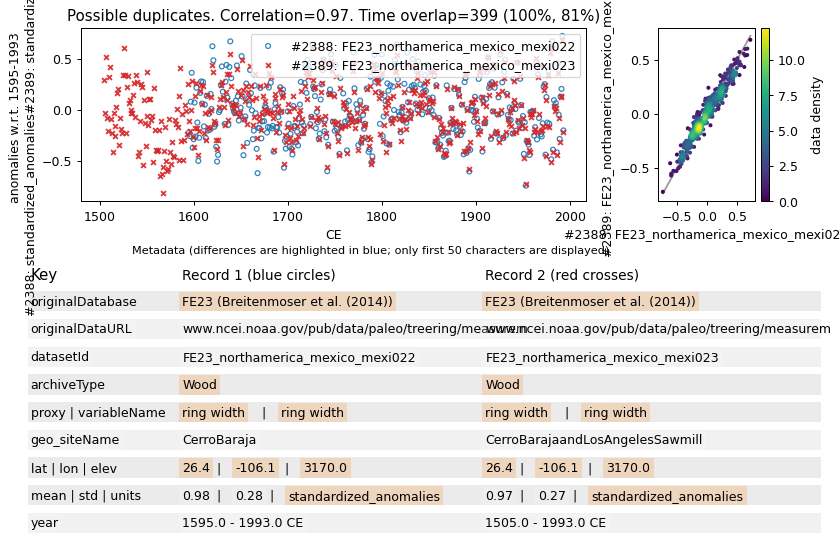

**Decision required for this duplicate pair (see figure above).**
Before inputting your decision. Would you like to leave a comment on your decision process?


 Please type your comment here and/or press enter. second record is an update/extension of the first, uses some of same .rwl data
Keep record 1 (FE23_northamerica_mexico_mexi022, blue circles) [1], record 2 (FE23_northamerica_mexico_mexi023, red crosses) [2], keep both [b], keep none [n] or create a composite of both records [c]?  [Type 1/2/b/n/c]: 2


saved figure in /home/jupyter-lluecke/dod2k_v2.0/dod2k/figs//dup_detection/all_merged/284_FE23_northamerica_mexico_mexi022_FE23_northamerica_mexico_mexi023__2388_2389.jpg
KEEP RED CROSSES: remove FE23_northamerica_mexico_mexi022, keep FE23_northamerica_mexico_mexi023.
write decision to backup file
2469 2522 277 285
> 286/429,FE23_australia_newz003,FE23_australia_newz060,0.0,0.9820284222987329
=== POTENTIAL DUPLICATE 285/429: FE23_australia_newz003+FE23_australia_newz060 ===
=== URL 1: https://www.ncei.noaa.gov/pub/data/paleo/treering/measurements/australia/newz003-noaa.rwl   ===
=== URL 2: https://www.ncei.noaa.gov/pub/data/paleo/treering/measurements/australia/newz060-noaa.rwl   ===
True if pot_dup_corrs[i_pot_dups]>=0.98 else False True
(len(time_1)==len(time_2)) False
metadata_identical:  True
lat True lon True elevation True archivetype True paleodata_proxy True
sites_identical:  False
URL_identical:  False
data_identical:  False
correlation_perfect:  False
Record 2 (FE23_australia

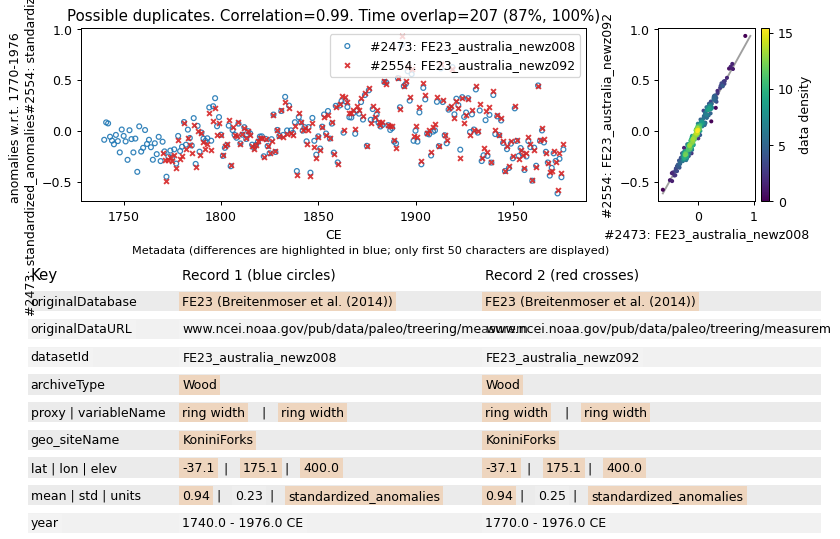

**Decision required for this duplicate pair (see figure above).**
Before inputting your decision. Would you like to leave a comment on your decision process?


 Please type your comment here and/or press enter. second record has greater replication over age interval than first
Keep record 1 (FE23_australia_newz008, blue circles) [1], record 2 (FE23_australia_newz092, red crosses) [2], keep both [b], keep none [n] or create a composite of both records [c]?  [Type 1/2/b/n/c]: 2


saved figure in /home/jupyter-lluecke/dod2k_v2.0/dod2k/figs//dup_detection/all_merged/286_FE23_australia_newz008_FE23_australia_newz092__2473_2554.jpg
KEEP RED CROSSES: remove FE23_australia_newz008, keep FE23_australia_newz092.
write decision to backup file
2477 2523 277 287
> 288/429,FE23_australia_newz014,FE23_australia_newz061,0.0,0.9830309576791556
=== POTENTIAL DUPLICATE 287/429: FE23_australia_newz014+FE23_australia_newz061 ===
=== URL 1: https://www.ncei.noaa.gov/pub/data/paleo/treering/measurements/australia/newz014-noaa.rwl   ===
=== URL 2: https://www.ncei.noaa.gov/pub/data/paleo/treering/measurements/australia/newz061-noaa.rwl   ===
True if pot_dup_corrs[i_pot_dups]>=0.98 else False True
(len(time_1)==len(time_2)) False
metadata_identical:  True
lat True lon True elevation True archivetype True paleodata_proxy True
sites_identical:  False
URL_identical:  False
data_identical:  False
correlation_perfect:  False
Record 2 (FE23_australia_newz061) is UPDATE of record 1 (FE23_au

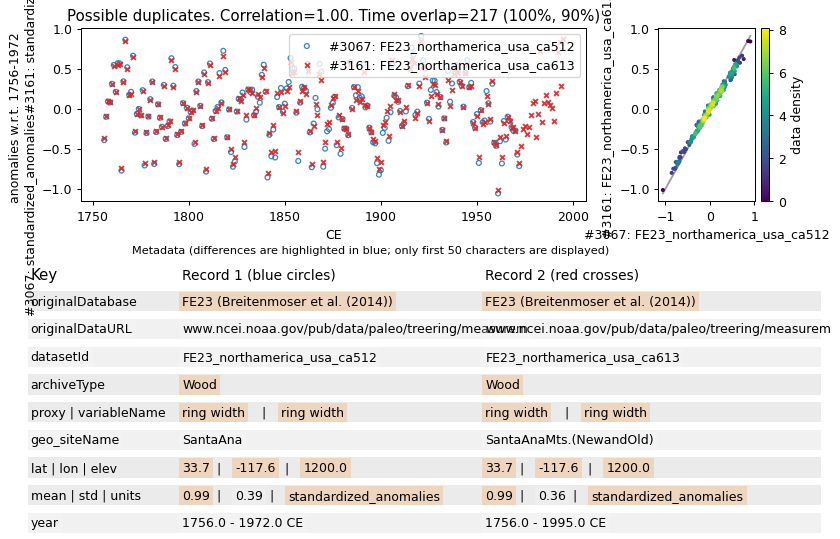

**Decision required for this duplicate pair (see figure above).**
Before inputting your decision. Would you like to leave a comment on your decision process?


 Please type your comment here and/or press enter. Record 2 an update of record 1
Keep record 1 (FE23_northamerica_usa_ca512, blue circles) [1], record 2 (FE23_northamerica_usa_ca613, red crosses) [2], keep both [b], keep none [n] or create a composite of both records [c]?  [Type 1/2/b/n/c]: 2


saved figure in /home/jupyter-lluecke/dod2k_v2.0/dod2k/figs//dup_detection/all_merged/292_FE23_northamerica_usa_ca512_FE23_northamerica_usa_ca613__3067_3161.jpg
KEEP RED CROSSES: remove FE23_northamerica_usa_ca512, keep FE23_northamerica_usa_ca613.
write decision to backup file
3084 3216 277 293
> 294/429,FE23_northamerica_usa_ca535,FE23_northamerica_usa_ca670,5.5596693510930715,0.9783723385582629
=== POTENTIAL DUPLICATE 293/429: FE23_northamerica_usa_ca535+FE23_northamerica_usa_ca670 ===
=== URL 1: https://www.ncei.noaa.gov/pub/data/paleo/treering/measurements/northamerica/usa/ca535-noaa.rwl   ===
=== URL 2: https://www.ncei.noaa.gov/pub/data/paleo/treering/measurements/northamerica/usa/ca670-noaa.rwl   ===
True if pot_dup_corrs[i_pot_dups]>=0.98 else False False
(len(time_1)==len(time_2)) False
metadata_identical:  True
lat True lon True elevation True archivetype True paleodata_proxy True
sites_identical:  False
URL_identical:  False
data_identical:  False
correlation_perfect:  Fals

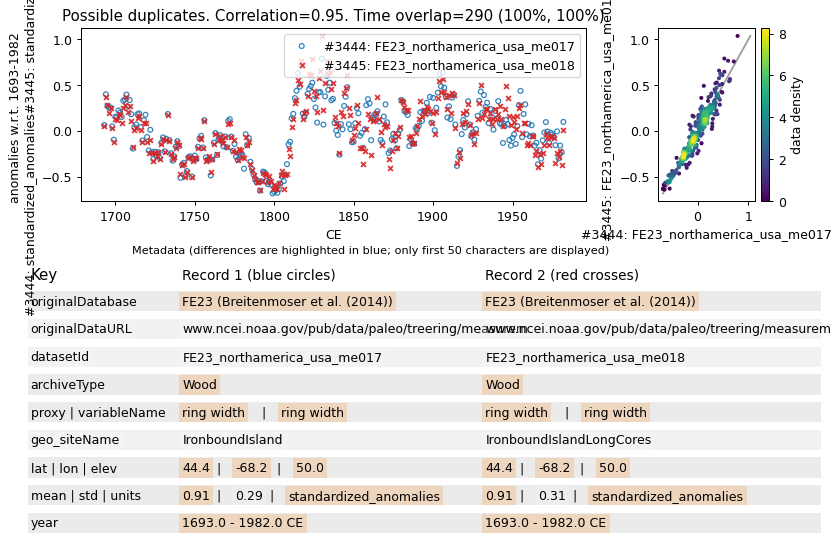

**Decision required for this duplicate pair (see figure above).**
Before inputting your decision. Would you like to leave a comment on your decision process?


 Please type your comment here and/or press enter. Rccord 2 is a chronology from long subset of record 1 increment records, choose record 2
Keep record 1 (FE23_northamerica_usa_me017, blue circles) [1], record 2 (FE23_northamerica_usa_me018, red crosses) [2], keep both [b], keep none [n] or create a composite of both records [c]?  [Type 1/2/b/n/c]: 2


saved figure in /home/jupyter-lluecke/dod2k_v2.0/dod2k/figs//dup_detection/all_merged/294_FE23_northamerica_usa_me017_FE23_northamerica_usa_me018__3444_3445.jpg
KEEP RED CROSSES: remove FE23_northamerica_usa_me017, keep FE23_northamerica_usa_me018.
write decision to backup file
3499 3508 277 295
> 296/429,FE23_northamerica_usa_mo,FE23_northamerica_usa_mo009,0.0,0.9984885968506374
=== POTENTIAL DUPLICATE 295/429: FE23_northamerica_usa_mo+FE23_northamerica_usa_mo009 ===
=== URL 1: https://www.ncei.noaa.gov/pub/data/paleo/treering/measurements/northamerica/usa/mo-noaa.rwl   ===
=== URL 2: https://www.ncei.noaa.gov/pub/data/paleo/treering/measurements/northamerica/usa/mo009-noaa.rwl   ===
True if pot_dup_corrs[i_pot_dups]>=0.98 else False True
(len(time_1)==len(time_2)) True
metadata_identical:  False
lat True lon True elevation False archivetype True paleodata_proxy True
sites_identical:  False
URL_identical:  False
data_identical:  False
correlation_perfect:  True
RECORDS IDENTICAL (perf

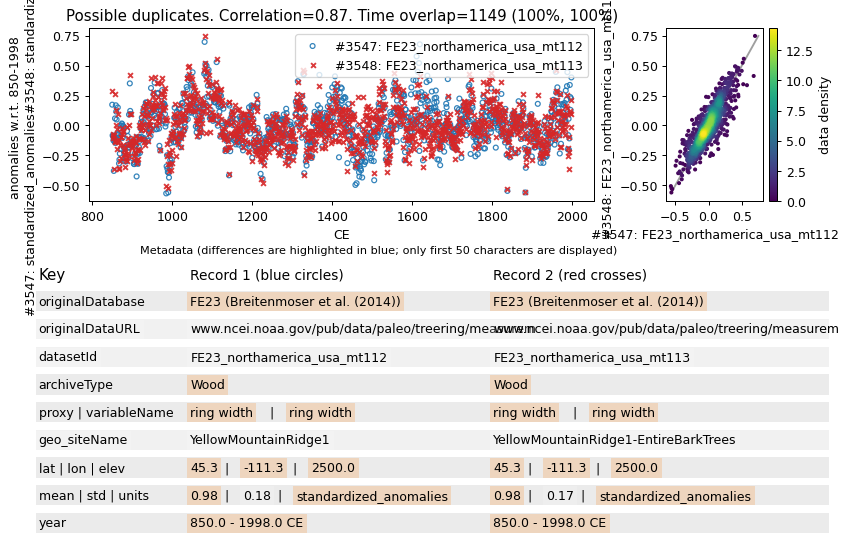

**Decision required for this duplicate pair (see figure above).**
Before inputting your decision. Would you like to leave a comment on your decision process?


 Please type your comment here and/or press enter. choose record 1 (all trees) because record 2 (entire bark trees) vs full chronology is r=0.87.  And FE23 processing controls to remove early period with low replication of increment records.
Keep record 1 (FE23_northamerica_usa_mt112, blue circles) [1], record 2 (FE23_northamerica_usa_mt113, red crosses) [2], keep both [b], keep none [n] or create a composite of both records [c]?  [Type 1/2/b/n/c]: 1


saved figure in /home/jupyter-lluecke/dod2k_v2.0/dod2k/figs//dup_detection/all_merged/296_FE23_northamerica_usa_mt112_FE23_northamerica_usa_mt113__3547_3548.jpg
KEEP BLUE CIRCLES: keep FE23_northamerica_usa_mt112, remove FE23_northamerica_usa_mt113.
write decision to backup file
3588 3589 277 297
> 298/429,FE23_northamerica_usa_nj001,FE23_northamerica_usa_nj002,0.0,0.9931763240446817
=== POTENTIAL DUPLICATE 297/429: FE23_northamerica_usa_nj001+FE23_northamerica_usa_nj002 ===
=== URL 1: https://www.ncei.noaa.gov/pub/data/paleo/treering/measurements/northamerica/usa/nj001-noaa.rwl   ===
=== URL 2: https://www.ncei.noaa.gov/pub/data/paleo/treering/measurements/northamerica/usa/nj002-noaa.rwl   ===
True if pot_dup_corrs[i_pot_dups]>=0.98 else False True
(len(time_1)==len(time_2)) False
metadata_identical:  True
lat True lon True elevation True archivetype True paleodata_proxy True
sites_identical:  False
URL_identical:  False
data_identical:  False
correlation_perfect:  False


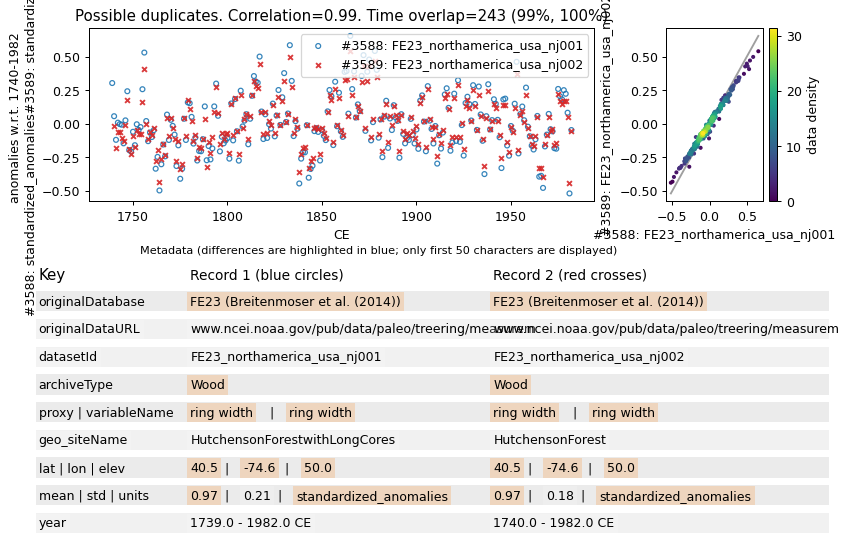

**Decision required for this duplicate pair (see figure above).**
Before inputting your decision. Would you like to leave a comment on your decision process?


 Please type your comment here and/or press enter. choose record 1, it is only 1 year longer because of fe23 replication requirements but is overall a few more series more replicated at site.
Keep record 1 (FE23_northamerica_usa_nj001, blue circles) [1], record 2 (FE23_northamerica_usa_nj002, red crosses) [2], keep both [b], keep none [n] or create a composite of both records [c]?  [Type 1/2/b/n/c]: 1


saved figure in /home/jupyter-lluecke/dod2k_v2.0/dod2k/figs//dup_detection/all_merged/297_FE23_northamerica_usa_nj001_FE23_northamerica_usa_nj002__3588_3589.jpg
KEEP BLUE CIRCLES: keep FE23_northamerica_usa_nj001, remove FE23_northamerica_usa_nj002.
write decision to backup file
3602 3628 277 298
> 299/429,FE23_northamerica_usa_nm024,FE23_northamerica_usa_nm055,0.0,0.9998373392446366
=== POTENTIAL DUPLICATE 298/429: FE23_northamerica_usa_nm024+FE23_northamerica_usa_nm055 ===
=== URL 1: https://www.ncei.noaa.gov/pub/data/paleo/treering/measurements/northamerica/usa/nm024-noaa.rwl   ===
=== URL 2: https://www.ncei.noaa.gov/pub/data/paleo/treering/measurements/northamerica/usa/nm055-noaa.rwl   ===
True if pot_dup_corrs[i_pot_dups]>=0.98 else False True
(len(time_1)==len(time_2)) True
metadata_identical:  True
lat True lon True elevation True archivetype True paleodata_proxy True
sites_identical:  True
URL_identical:  False
data_identical:  False
correlation_perfect:  True
RECORDS IDENTICA

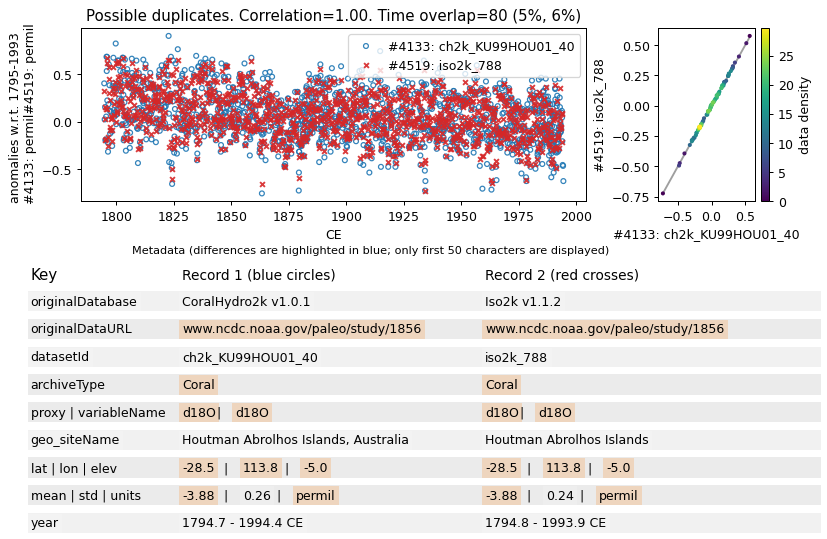

**Decision required for this duplicate pair (see figure above).**
Before inputting your decision. Would you like to leave a comment on your decision process?


 Please type your comment here and/or press enter. These seem to be the same record, but interpolated or reported on slightly different time axes.  Choose iso2k version because it is consistent with the originalDataURL.
Keep record 1 (ch2k_KU99HOU01_40, blue circles) [1], record 2 (iso2k_788, red crosses) [2], keep both [b], keep none [n] or create a composite of both records [c]?  [Type 1/2/b/n/c]: 2


saved figure in /home/jupyter-lluecke/dod2k_v2.0/dod2k/figs//dup_detection/all_merged/313_ch2k_KU99HOU01_40_iso2k_788__4133_4519.jpg
KEEP RED CROSSES: remove ch2k_KU99HOU01_40, keep iso2k_788.
write decision to backup file
4138 4456 277 314
> 315/429,ch2k_NU11PAL01_52,iso2k_505,0.46978588358468626,0.9965291826467186
=== POTENTIAL DUPLICATE 314/429: ch2k_NU11PAL01_52+iso2k_505 ===
=== URL 1: https://www.ncdc.noaa.gov/paleo/study/10373   ===
=== URL 2: https://www.ncdc.noaa.gov/paleo/study/1875   ===
True if pot_dup_corrs[i_pot_dups]>=0.98 else False True
(len(time_1)==len(time_2)) False
metadata_identical:  False
lat True lon True elevation False archivetype True paleodata_proxy True
sites_identical:  False
URL_identical:  False
data_identical:  False
correlation_perfect:  False


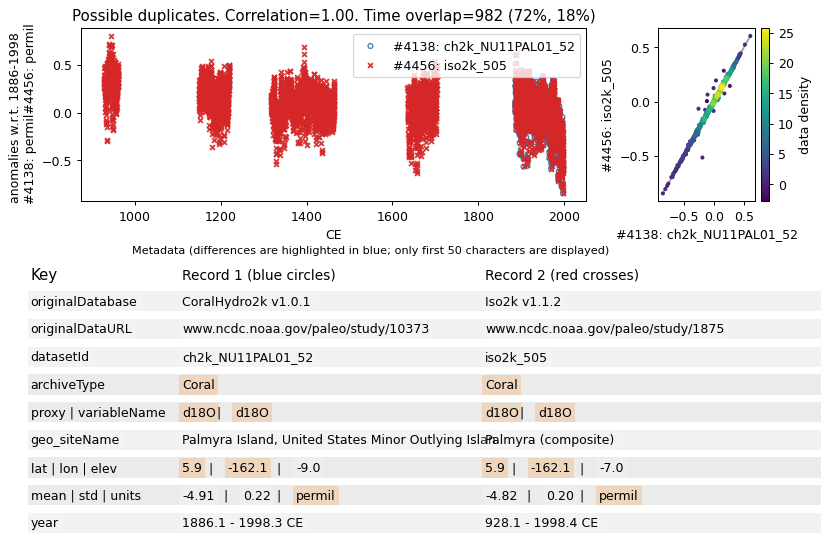

**Decision required for this duplicate pair (see figure above).**
Before inputting your decision. Would you like to leave a comment on your decision process?


 Please type your comment here and/or press enter. choose the iso2k composite Palmyra record
Keep record 1 (ch2k_NU11PAL01_52, blue circles) [1], record 2 (iso2k_505, red crosses) [2], keep both [b], keep none [n] or create a composite of both records [c]?  [Type 1/2/b/n/c]: 2


saved figure in /home/jupyter-lluecke/dod2k_v2.0/dod2k/figs//dup_detection/all_merged/314_ch2k_NU11PAL01_52_iso2k_505__4138_4456.jpg
KEEP RED CROSSES: remove ch2k_NU11PAL01_52, keep iso2k_505.
write decision to backup file
4138 4482 277 315
> 316/429,ch2k_NU11PAL01_52,iso2k_579,0.46978588358468626,0.9992710430546083
=== POTENTIAL DUPLICATE 315/429: ch2k_NU11PAL01_52+iso2k_579 ===
=== URL 1: https://www.ncdc.noaa.gov/paleo/study/10373   ===
=== URL 2: https://www.ncdc.noaa.gov/paleo/study/10373   ===
True if pot_dup_corrs[i_pot_dups]>=0.98 else False True
(len(time_1)==len(time_2)) True
metadata_identical:  True
lat True lon True elevation True archivetype True paleodata_proxy True
sites_identical:  False
URL_identical:  True
data_identical:  False
correlation_perfect:  True
RECORDS IDENTICAL (perfect correlation) except for metadata. Automatically choose #2.
KEEP RED CROSSES: remove ch2k_NU11PAL01_52, keep iso2k_579.
write decision to backup file
4141 4445 277 316
> 317/429,ch2k_CA14TI

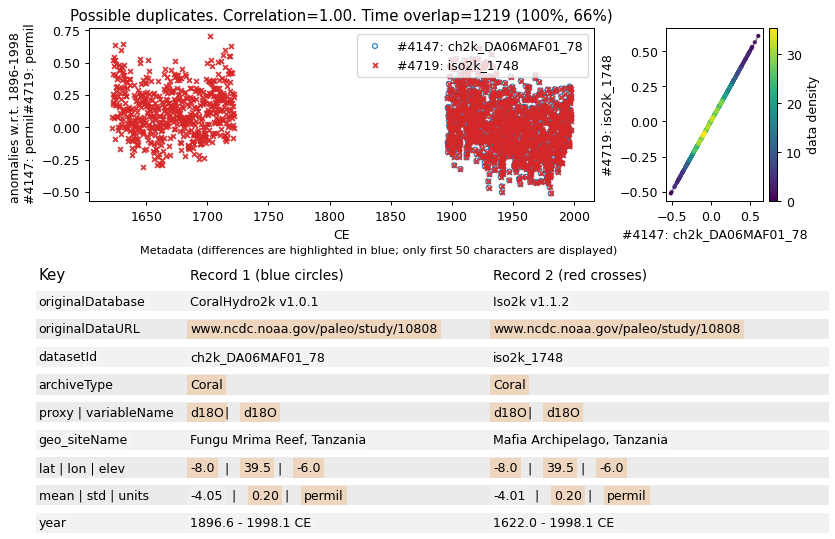

**Decision required for this duplicate pair (see figure above).**
Before inputting your decision. Would you like to leave a comment on your decision process?


 Please type your comment here and/or press enter. choose the iso2k composite record from the same site.
Keep record 1 (ch2k_DA06MAF01_78, blue circles) [1], record 2 (iso2k_1748, red crosses) [2], keep both [b], keep none [n] or create a composite of both records [c]?  [Type 1/2/b/n/c]: 2


saved figure in /home/jupyter-lluecke/dod2k_v2.0/dod2k/figs//dup_detection/all_merged/318_ch2k_DA06MAF01_78_iso2k_1748__4147_4719.jpg
KEEP RED CROSSES: remove ch2k_DA06MAF01_78, keep iso2k_1748.
write decision to backup file
4148 4722 277 319
> 320/429,ch2k_NA09MAL01_84,iso2k_1754,0.0,0.9999999999999999
=== POTENTIAL DUPLICATE 319/429: ch2k_NA09MAL01_84+iso2k_1754 ===
=== URL 1: https://www.ncdc.noaa.gov/paleo/study/12994   ===
=== URL 2: https://www.ncdc.noaa.gov/paleo/study/12994   ===
True if pot_dup_corrs[i_pot_dups]>=0.98 else False True
(len(time_1)==len(time_2)) True
metadata_identical:  False
lat True lon True elevation False archivetype True paleodata_proxy True
sites_identical:  False
URL_identical:  True
data_identical:  False
correlation_perfect:  True
RECORDS IDENTICAL (perfect correlation) except for metadata. Automatically choose #2.
KEEP RED CROSSES: remove ch2k_NA09MAL01_84, keep iso2k_1754.
write decision to backup file
4149 4349 277 320
> 321/429,ch2k_SW98STP01_86,is

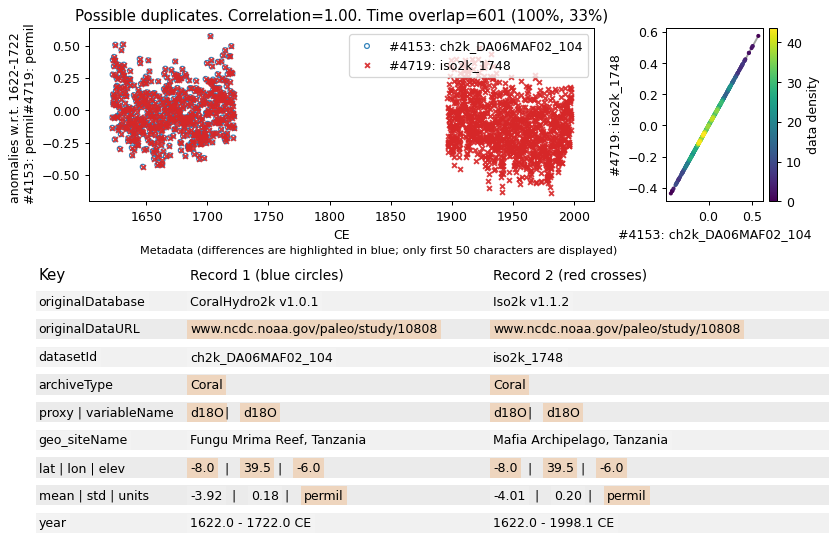

**Decision required for this duplicate pair (see figure above).**
Before inputting your decision. Would you like to leave a comment on your decision process?


 Please type your comment here and/or press enter. choose the iso2k composite record from the same site.
Keep record 1 (ch2k_DA06MAF02_104, blue circles) [1], record 2 (iso2k_1748, red crosses) [2], keep both [b], keep none [n] or create a composite of both records [c]?  [Type 1/2/b/n/c]: 2


saved figure in /home/jupyter-lluecke/dod2k_v2.0/dod2k/figs//dup_detection/all_merged/321_ch2k_DA06MAF02_104_iso2k_1748__4153_4719.jpg
KEEP RED CROSSES: remove ch2k_DA06MAF02_104, keep iso2k_1748.
write decision to backup file
4156 4457 277 322
> 323/429,ch2k_CO03PAL01_110,iso2k_507,0.0,1.0
=== POTENTIAL DUPLICATE 322/429: ch2k_CO03PAL01_110+iso2k_507 ===
=== URL 1: https://www.ncdc.noaa.gov/paleo/study/1875   ===
=== URL 2: https://www.ncdc.noaa.gov/paleo/study/1875   ===
True if pot_dup_corrs[i_pot_dups]>=0.98 else False True
(len(time_1)==len(time_2)) True
metadata_identical:  True
lat True lon True elevation True archivetype True paleodata_proxy True
sites_identical:  False
URL_identical:  True
data_identical:  True
correlation_perfect:  True
RECORDS IDENTICAL (identical data) except for metadata. Automatically choose #2.
KEEP RED CROSSES: remove ch2k_CO03PAL01_110, keep iso2k_507.
write decision to backup file
4159 4611 277 323
> 324/429,ch2k_CH98PIR01_116,iso2k_1229,0.0,1.0
=== P

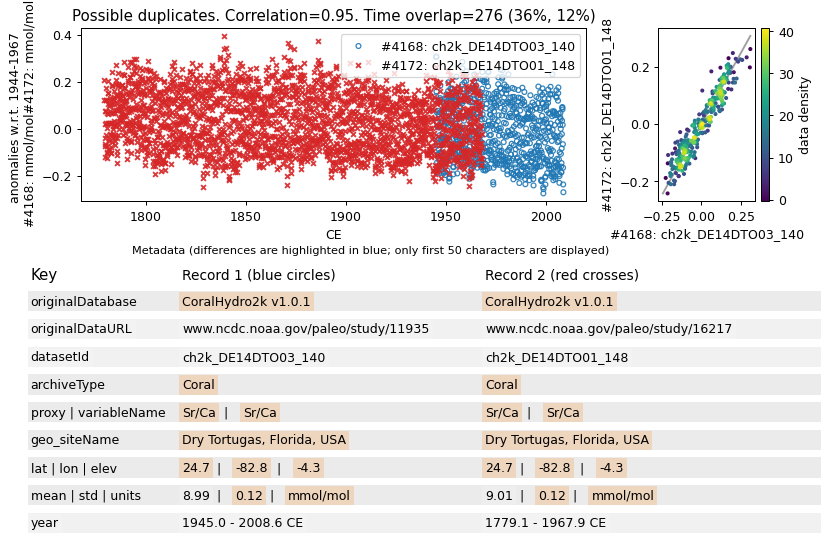

**Decision required for this duplicate pair (see figure above).**
Before inputting your decision. Would you like to leave a comment on your decision process?


 Please type your comment here and/or press enter. choose neither, thinking the composite record (1732-2008) is in the aggregate database
Keep record 1 (ch2k_DE14DTO03_140, blue circles) [1], record 2 (ch2k_DE14DTO01_148, red crosses) [2], keep both [b], keep none [n] or create a composite of both records [c]?  [Type 1/2/b/n/c]: n


saved figure in /home/jupyter-lluecke/dod2k_v2.0/dod2k/figs//dup_detection/all_merged/328_ch2k_DE14DTO03_140_ch2k_DE14DTO01_148__4168_4172.jpg
REMOVE BOTH: remove ch2k_DE14DTO01_148, remove ch2k_DE14DTO03_140.
write decision to backup file
4170 4626 277 329
> 330/429,ch2k_QU06RAB01_144,iso2k_1311,1.3265164823623186,0.9998938624989858
=== POTENTIAL DUPLICATE 329/429: ch2k_QU06RAB01_144+iso2k_1311 ===
=== URL 1: https://www.ncdc.noaa.gov/paleo/study/6116   ===
=== URL 2: https://www.ncdc.noaa.gov/paleo/study/6116   ===
True if pot_dup_corrs[i_pot_dups]>=0.98 else False True
(len(time_1)==len(time_2)) True
metadata_identical:  True
lat True lon True elevation True archivetype True paleodata_proxy True
sites_identical:  False
URL_identical:  True
data_identical:  False
correlation_perfect:  True
RECORDS IDENTICAL (perfect correlation) except for metadata. Automatically choose #2.
KEEP RED CROSSES: remove ch2k_QU06RAB01_144, keep iso2k_1311.
write decision to backup file
4173 4672 277 330
>

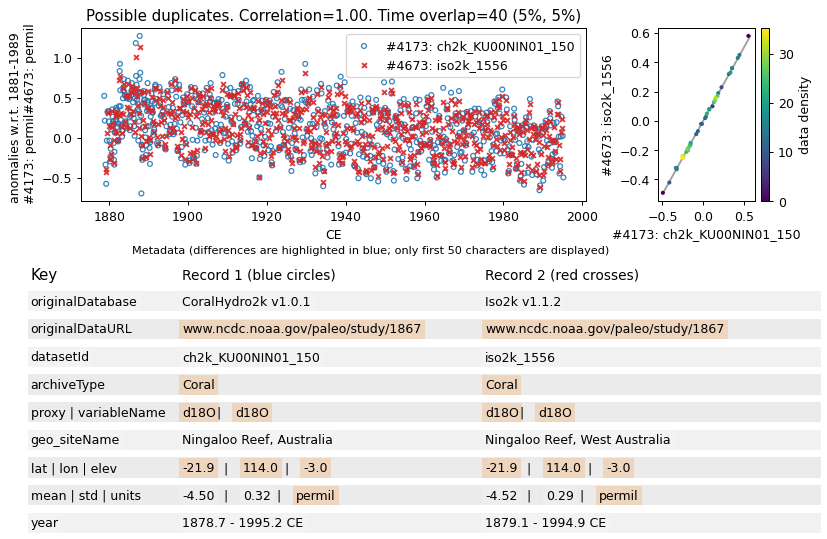

**Decision required for this duplicate pair (see figure above).**
Before inputting your decision. Would you like to leave a comment on your decision process?


 Please type your comment here and/or press enter. choose iso2k version as that which is consistent with published age model in originalDataURL.
Keep record 1 (ch2k_KU00NIN01_150, blue circles) [1], record 2 (iso2k_1556, red crosses) [2], keep both [b], keep none [n] or create a composite of both records [c]?  [Type 1/2/b/n/c]: 2


saved figure in /home/jupyter-lluecke/dod2k_v2.0/dod2k/figs//dup_detection/all_merged/331_ch2k_KU00NIN01_150_iso2k_1556__4173_4673.jpg
KEEP RED CROSSES: remove ch2k_KU00NIN01_150, keep iso2k_1556.
write decision to backup file
4187 4188 277 332
> 333/429,ch2k_EV18ROC01_184,ch2k_EV18ROC01_186,0.0,1.0
=== POTENTIAL DUPLICATE 332/429: ch2k_EV18ROC01_184+ch2k_EV18ROC01_186 ===
=== URL 1: https://www.ncdc.noaa.gov/paleo/study/34373   ===
=== URL 2: https://www.ncdc.noaa.gov/paleo/study/34373   ===
True if pot_dup_corrs[i_pot_dups]>=0.98 else False True
(len(time_1)==len(time_2)) True
metadata_identical:  True
lat True lon True elevation True archivetype True paleodata_proxy True
sites_identical:  True
URL_identical:  True
data_identical:  True
correlation_perfect:  True
RECORDS IDENTICAL (identical data). Automatically choose #1.
KEEP BLUE CIRCLES: keep ch2k_EV18ROC01_184, remove ch2k_EV18ROC01_186.
write decision to backup file
4189 4478 277 333
> 334/429,ch2k_CA13SAP01_188,iso2k_569,0.038

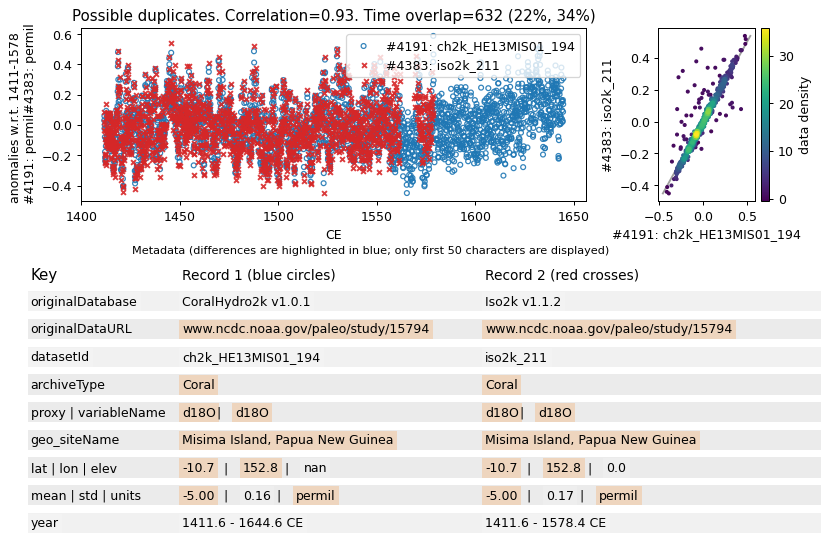

**Decision required for this duplicate pair (see figure above).**
Before inputting your decision. Would you like to leave a comment on your decision process?


 Please type your comment here and/or press enter. choose iso2k composite fossil and modern record.
Keep record 1 (ch2k_HE13MIS01_194, blue circles) [1], record 2 (iso2k_211, red crosses) [2], keep both [b], keep none [n] or create a composite of both records [c]?  [Type 1/2/b/n/c]: 2


saved figure in /home/jupyter-lluecke/dod2k_v2.0/dod2k/figs//dup_detection/all_merged/334_ch2k_HE13MIS01_194_iso2k_211__4191_4383.jpg
KEEP RED CROSSES: remove ch2k_HE13MIS01_194, keep iso2k_211.
write decision to backup file
4191 4384 277 335
> 336/429,ch2k_HE13MIS01_194,iso2k_213,0.18098363234620218,0.993099103724861
=== POTENTIAL DUPLICATE 335/429: ch2k_HE13MIS01_194+iso2k_213 ===
=== URL 1: https://www.ncdc.noaa.gov/paleo/study/15794   ===
=== URL 2: https://www.ncdc.noaa.gov/paleo/study/15794   ===
True if pot_dup_corrs[i_pot_dups]>=0.98 else False True
(len(time_1)==len(time_2)) False
metadata_identical:  True
lat True lon True elevation True archivetype True paleodata_proxy True
sites_identical:  True
URL_identical:  True
data_identical:  False
correlation_perfect:  False


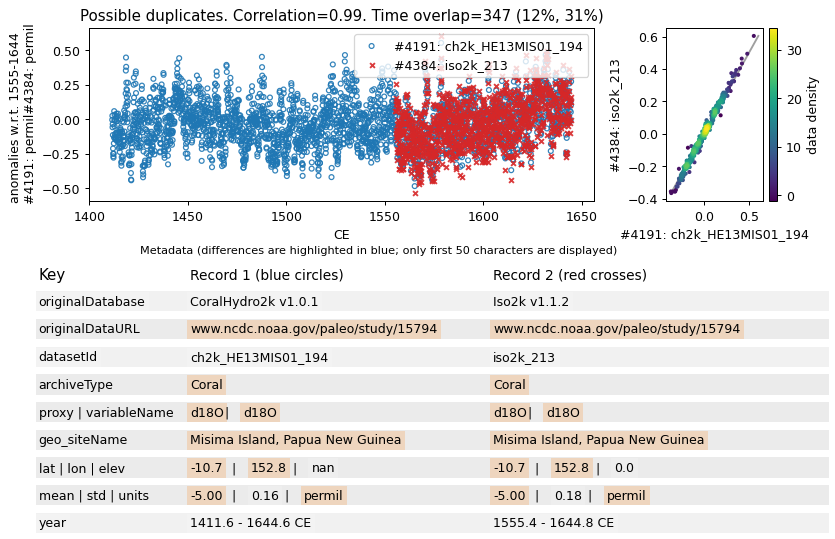

**Decision required for this duplicate pair (see figure above).**
Before inputting your decision. Would you like to leave a comment on your decision process?


 Please type your comment here and/or press enter. choose neither, we already have the composite fossil + modern record.
Keep record 1 (ch2k_HE13MIS01_194, blue circles) [1], record 2 (iso2k_213, red crosses) [2], keep both [b], keep none [n] or create a composite of both records [c]?  [Type 1/2/b/n/c]: n


saved figure in /home/jupyter-lluecke/dod2k_v2.0/dod2k/figs//dup_detection/all_merged/335_ch2k_HE13MIS01_194_iso2k_213__4191_4384.jpg
REMOVE BOTH: remove iso2k_213, remove ch2k_HE13MIS01_194.
write decision to backup file
4193 4194 277 336
> 337/429,ch2k_ZI15IMP02_200,ch2k_ZI15IMP02_202,0.0,1.0
=== POTENTIAL DUPLICATE 336/429: ch2k_ZI15IMP02_200+ch2k_ZI15IMP02_202 ===
=== URL 1: https://www.ncdc.noaa.gov/paleo/study/19239   ===
=== URL 2: https://www.ncdc.noaa.gov/paleo/study/19239   ===
True if pot_dup_corrs[i_pot_dups]>=0.98 else False True
(len(time_1)==len(time_2)) True
metadata_identical:  True
lat True lon True elevation True archivetype True paleodata_proxy True
sites_identical:  True
URL_identical:  True
data_identical:  True
correlation_perfect:  True
RECORDS IDENTICAL (identical data). Automatically choose #1.
KEEP BLUE CIRCLES: keep ch2k_ZI15IMP02_200, remove ch2k_ZI15IMP02_202.
write decision to backup file
4195 4705 277 337
> 338/429,ch2k_PF04PBA01_204,iso2k_1701,0.0,1.0
=

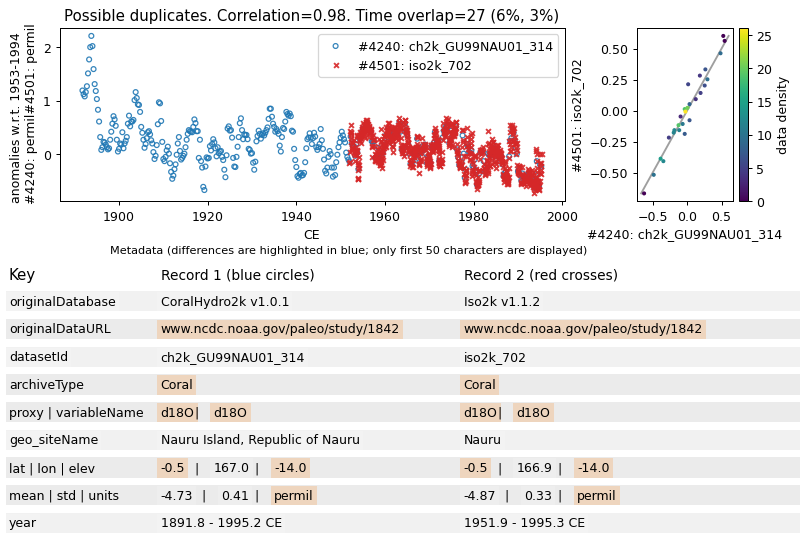

**Decision required for this duplicate pair (see figure above).**
Before inputting your decision. Would you like to leave a comment on your decision process?


 Please type your comment here and/or press enter. keep full ch2k record, with knowledge there is questionable interpretation as climate of the earliest part of the Nauru composite record (pre-1900).
Keep record 1 (ch2k_GU99NAU01_314, blue circles) [1], record 2 (iso2k_702, red crosses) [2], keep both [b], keep none [n] or create a composite of both records [c]?  [Type 1/2/b/n/c]: 1


saved figure in /home/jupyter-lluecke/dod2k_v2.0/dod2k/figs//dup_detection/all_merged/350_ch2k_GU99NAU01_314_iso2k_702__4240_4501.jpg
KEEP BLUE CIRCLES: keep ch2k_GU99NAU01_314, remove iso2k_702.
write decision to backup file
4240 4502 277 351
> 352/429,ch2k_GU99NAU01_314,iso2k_705,4.70176061145538,1.0
=== POTENTIAL DUPLICATE 351/429: ch2k_GU99NAU01_314+iso2k_705 ===
=== URL 1: https://www.ncdc.noaa.gov/paleo/study/1842   ===
=== URL 2: https://www.ncdc.noaa.gov/paleo/study/1842   ===
True if pot_dup_corrs[i_pot_dups]>=0.98 else False True
(len(time_1)==len(time_2)) True
metadata_identical:  True
lat True lon True elevation True archivetype True paleodata_proxy True
sites_identical:  False
URL_identical:  True
data_identical:  True
correlation_perfect:  True
RECORDS IDENTICAL (identical data) except for metadata. Automatically choose #2.
KEEP RED CROSSES: remove ch2k_GU99NAU01_314, keep iso2k_705.
write decision to backup file
4243 4463 277 352
> 353/429,ch2k_CO03PAL10_324,iso2k_519,0.

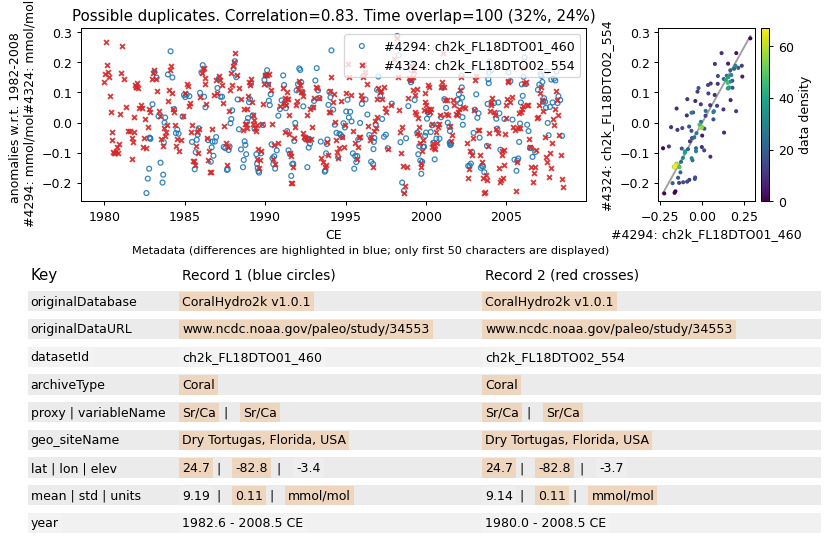

**Decision required for this duplicate pair (see figure above).**
Before inputting your decision. Would you like to leave a comment on your decision process?


 Please type your comment here and/or press enter. Valuable calibration study, but because record lengths are 1980-2008, keeping neither for the dod2k purposes.
Keep record 1 (ch2k_FL18DTO01_460, blue circles) [1], record 2 (ch2k_FL18DTO02_554, red crosses) [2], keep both [b], keep none [n] or create a composite of both records [c]?  [Type 1/2/b/n/c]: n


saved figure in /home/jupyter-lluecke/dod2k_v2.0/dod2k/figs//dup_detection/all_merged/372_ch2k_FL18DTO01_460_ch2k_FL18DTO02_554__4294_4324.jpg
REMOVE BOTH: remove ch2k_FL18DTO02_554, remove ch2k_FL18DTO01_460.
write decision to backup file
4297 4298 277 373
> 374/429,ch2k_DU94URV01_468,ch2k_DU94URV01_470,0.0,1.0
=== POTENTIAL DUPLICATE 373/429: ch2k_DU94URV01_468+ch2k_DU94URV01_470 ===
=== URL 1: https://www.ncdc.noaa.gov/paleo/study/1850   ===
=== URL 2: https://www.ncdc.noaa.gov/paleo/study/1850   ===
True if pot_dup_corrs[i_pot_dups]>=0.98 else False True
(len(time_1)==len(time_2)) True
metadata_identical:  True
lat True lon True elevation True archivetype True paleodata_proxy True
sites_identical:  True
URL_identical:  True
data_identical:  True
correlation_perfect:  True
RECORDS IDENTICAL (identical data). Automatically choose #1.
KEEP BLUE CIRCLES: keep ch2k_DU94URV01_468, remove ch2k_DU94URV01_470.
write decision to backup file
4299 4465 277 374
> 375/429,ch2k_CO03PAL08_472,iso2

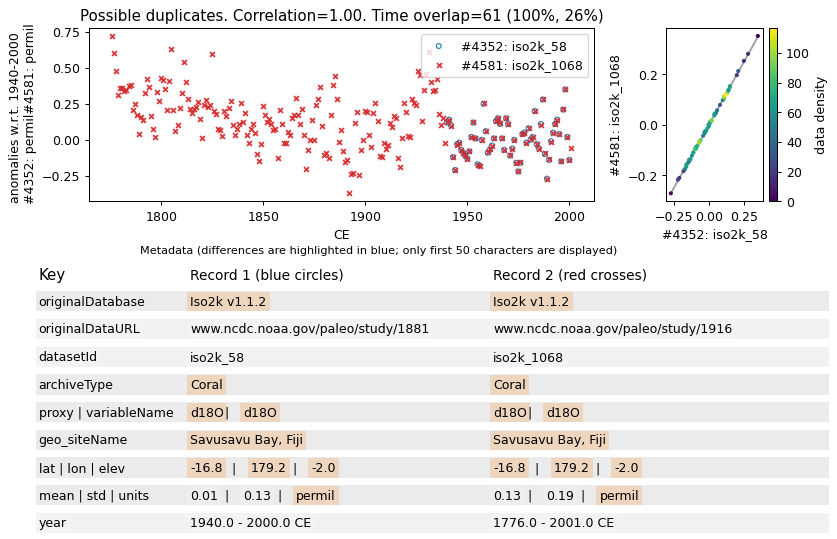

**Decision required for this duplicate pair (see figure above).**
Before inputting your decision. Would you like to leave a comment on your decision process?


 Please type your comment here and/or press enter. keeping the time composite, recognizing there are questions in literature about the interpretation of the earliest few years (1770s).
Keep record 1 (iso2k_58, blue circles) [1], record 2 (iso2k_1068, red crosses) [2], keep both [b], keep none [n] or create a composite of both records [c]?  [Type 1/2/b/n/c]: 2


saved figure in /home/jupyter-lluecke/dod2k_v2.0/dod2k/figs//dup_detection/all_merged/387_iso2k_58_iso2k_1068__4352_4581.jpg
KEEP RED CROSSES: remove iso2k_58, keep iso2k_1068.
write decision to backup file
4362 4363 277 388
> 389/429,iso2k_94,iso2k_98,0.0,1.0
=== POTENTIAL DUPLICATE 388/429: iso2k_94+iso2k_98 ===
=== URL 1: https://www.ncdc.noaa.gov/paleo/study/1859   ===
=== URL 2: https://www.ncdc.noaa.gov/paleo/study/1859   ===
True if pot_dup_corrs[i_pot_dups]>=0.98 else False True
(len(time_1)==len(time_2)) True
metadata_identical:  True
lat True lon True elevation True archivetype True paleodata_proxy True
sites_identical:  True
URL_identical:  True
data_identical:  True
correlation_perfect:  True
RECORDS IDENTICAL (identical data). Automatically choose #1.
KEEP BLUE CIRCLES: keep iso2k_94, remove iso2k_98.
write decision to backup file
4370 4945 277 389
> 390/429,iso2k_120,sisal_253.0_171,0.06728323958312438,1.0
=== POTENTIAL DUPLICATE 389/429: iso2k_120+sisal_253.0_171 ===
===

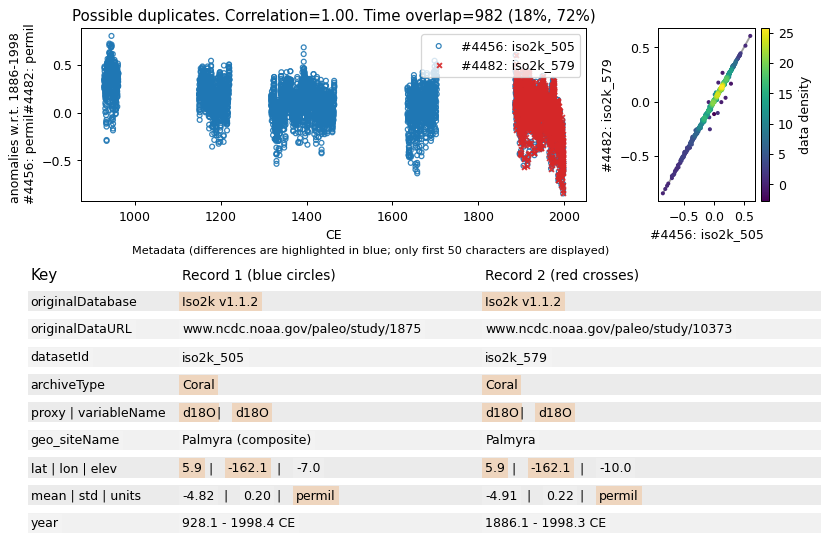

**Decision required for this duplicate pair (see figure above).**
Before inputting your decision. Would you like to leave a comment on your decision process?


 Please type your comment here and/or press enter. keeping Palmyra composite record, but this might be the pre-2020 version.
Keep record 1 (iso2k_505, blue circles) [1], record 2 (iso2k_579, red crosses) [2], keep both [b], keep none [n] or create a composite of both records [c]?  [Type 1/2/b/n/c]: 1


saved figure in /home/jupyter-lluecke/dod2k_v2.0/dod2k/figs//dup_detection/all_merged/398_iso2k_505_iso2k_579__4456_4482.jpg
KEEP BLUE CIRCLES: keep iso2k_505, remove iso2k_579.
write decision to backup file
4468 4843 277 399
> 400/429,iso2k_533,sisal_115.0_69,0.4944092732924204,0.9999999999999998
=== POTENTIAL DUPLICATE 399/429: iso2k_533+sisal_115.0_69 ===
=== URL 1: https://www.ncdc.noaa.gov/paleo-search/study/5427   ===
=== URL 2: ['10.1126/science.1091220']   ===
True if pot_dup_corrs[i_pot_dups]>=0.98 else False True
(len(time_1)==len(time_2)) False
metadata_identical:  False
lat True lon True elevation True archivetype False paleodata_proxy True
sites_identical:  False
URL_identical:  False
data_identical:  False
correlation_perfect:  False


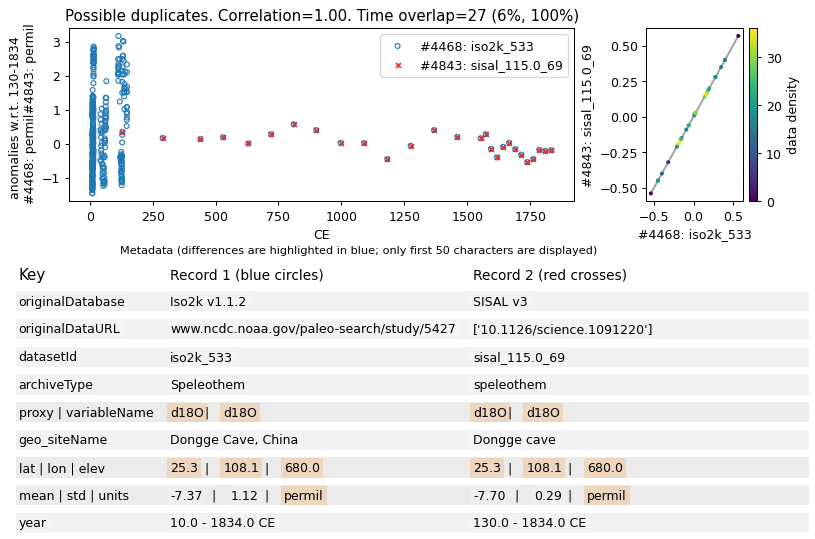

**Decision required for this duplicate pair (see figure above).**
Before inputting your decision. Would you like to leave a comment on your decision process?


 Please type your comment here and/or press enter. choose sisalv3 series as consistent with data from originalDataURL 
Keep record 1 (iso2k_533, blue circles) [1], record 2 (sisal_115.0_69, red crosses) [2], keep both [b], keep none [n] or create a composite of both records [c]?  [Type 1/2/b/n/c]: 2


saved figure in /home/jupyter-lluecke/dod2k_v2.0/dod2k/figs//dup_detection/all_merged/399_iso2k_533_sisal_115.0_69__4468_4843.jpg
KEEP RED CROSSES: remove iso2k_533, keep sisal_115.0_69.
write decision to backup file
4471 4473 277 400
> 401/429,iso2k_546,iso2k_549,0.0,0.9992915900641419
=== POTENTIAL DUPLICATE 400/429: iso2k_546+iso2k_549 ===
=== URL 1: this compilation   ===
=== URL 2: this compilation   ===
True if pot_dup_corrs[i_pot_dups]>=0.98 else False True
(len(time_1)==len(time_2)) True
metadata_identical:  True
lat True lon True elevation True archivetype True paleodata_proxy True
sites_identical:  True
URL_identical:  True
data_identical:  False
correlation_perfect:  True
RECORDS IDENTICAL (perfect correlation). Automatically choose #1.
KEEP BLUE CIRCLES: keep iso2k_546, remove iso2k_549.
write decision to backup file
4472 4474 277 401
> 402/429,iso2k_547,iso2k_550,0.0,0.9996157576286442
=== POTENTIAL DUPLICATE 401/429: iso2k_547+iso2k_550 ===
=== URL 1: this compilation   =

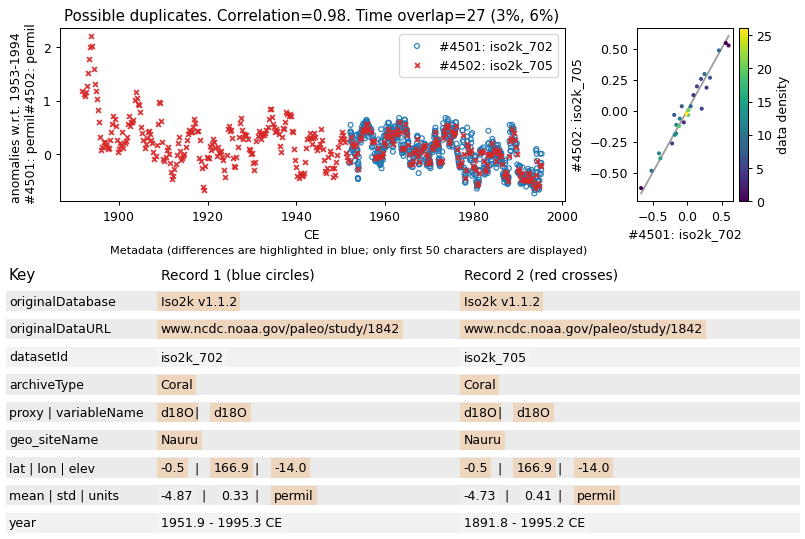

**Decision required for this duplicate pair (see figure above).**
Before inputting your decision. Would you like to leave a comment on your decision process?


 Please type your comment here and/or press enter. choose 2 as the composite site record again
Keep record 1 (iso2k_702, blue circles) [1], record 2 (iso2k_705, red crosses) [2], keep both [b], keep none [n] or create a composite of both records [c]?  [Type 1/2/b/n/c]: 2


saved figure in /home/jupyter-lluecke/dod2k_v2.0/dod2k/figs//dup_detection/all_merged/402_iso2k_702_iso2k_705__4501_4502.jpg
KEEP RED CROSSES: remove iso2k_702, keep iso2k_705.
write decision to backup file
4514 4515 277 403
> 404/429,iso2k_772,iso2k_775,0.0,1.0
=== POTENTIAL DUPLICATE 403/429: iso2k_772+iso2k_775 ===
=== URL 1: https://www.ncdc.noaa.gov/paleo/study/9792   ===
=== URL 2: https://www.ncdc.noaa.gov/paleo/study/9792   ===
True if pot_dup_corrs[i_pot_dups]>=0.98 else False True
(len(time_1)==len(time_2)) True
metadata_identical:  True
lat True lon True elevation True archivetype True paleodata_proxy True
sites_identical:  True
URL_identical:  True
data_identical:  True
correlation_perfect:  True
RECORDS IDENTICAL (identical data). Automatically choose #1.
KEEP BLUE CIRCLES: keep iso2k_772, remove iso2k_775.
write decision to backup file
4518 4519 277 404
> 405/429,iso2k_786,iso2k_788,0.0,0.9997021095883626
=== POTENTIAL DUPLICATE 404/429: iso2k_786+iso2k_788 ===
=== URL 1:

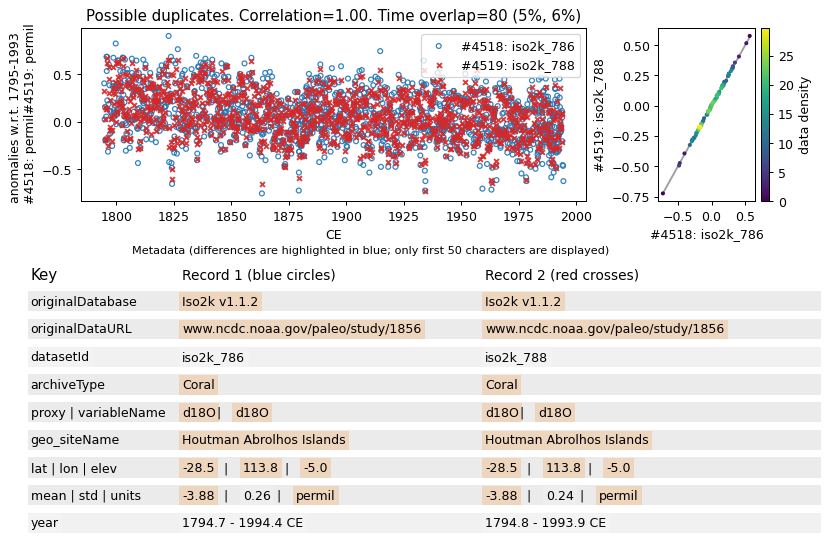

**Decision required for this duplicate pair (see figure above).**
Before inputting your decision. Would you like to leave a comment on your decision process?


 Please type your comment here and/or press enter. record 2 from iso2k consistent with agemodel from originalDataURL
Keep record 1 (iso2k_786, blue circles) [1], record 2 (iso2k_788, red crosses) [2], keep both [b], keep none [n] or create a composite of both records [c]?  [Type 1/2/b/n/c]: 2


saved figure in /home/jupyter-lluecke/dod2k_v2.0/dod2k/figs//dup_detection/all_merged/404_iso2k_786_iso2k_788__4518_4519.jpg
KEEP RED CROSSES: remove iso2k_786, keep iso2k_788.
write decision to backup file
4521 4522 277 405
> 406/429,iso2k_806,iso2k_811,0.0,1.0
=== POTENTIAL DUPLICATE 405/429: iso2k_806+iso2k_811 ===
=== URL 1: https://doi.org/10.25921/6e73-as97   ===
=== URL 2: https://doi.org/10.25921/6e73-as97   ===
True if pot_dup_corrs[i_pot_dups]>=0.98 else False True
(len(time_1)==len(time_2)) True
metadata_identical:  True
lat True lon True elevation True archivetype True paleodata_proxy True
sites_identical:  True
URL_identical:  True
data_identical:  True
correlation_perfect:  True
RECORDS IDENTICAL (identical data). Automatically choose #1.
KEEP BLUE CIRCLES: keep iso2k_806, remove iso2k_811.
write decision to backup file
4539 5088 277 406
> 407/429,iso2k_873,sisal_471.0_314,2.2239525755535694,0.9919284483744666
=== POTENTIAL DUPLICATE 406/429: iso2k_873+sisal_471.0_314 ===

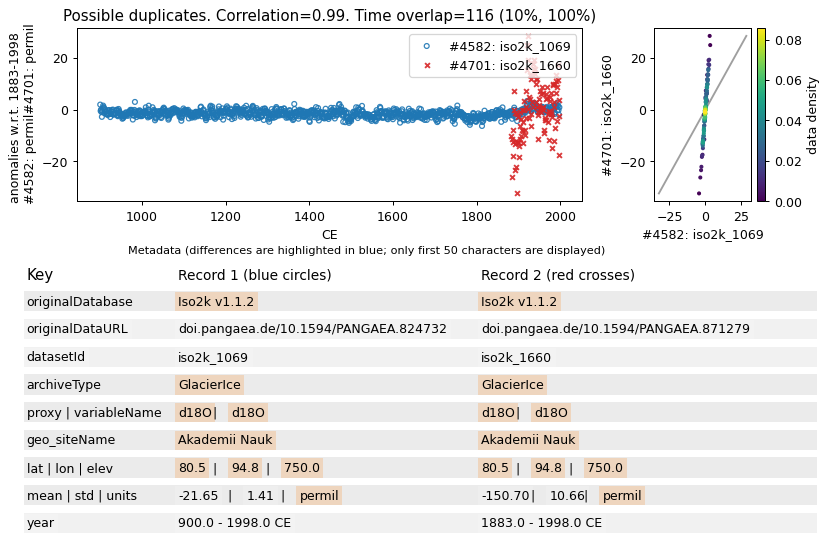

**Decision required for this duplicate pair (see figure above).**
Before inputting your decision. Would you like to leave a comment on your decision process?


 Please type your comment here and/or press enter. record 1 is composite d18O (modern + millennial), record 2 is modern dD record, 
Keep record 1 (iso2k_1069, blue circles) [1], record 2 (iso2k_1660, red crosses) [2], keep both [b], keep none [n] or create a composite of both records [c]?  [Type 1/2/b/n/c]: 1


saved figure in /home/jupyter-lluecke/dod2k_v2.0/dod2k/figs//dup_detection/all_merged/407_iso2k_1069_iso2k_1660__4582_4701.jpg
KEEP BLUE CIRCLES: keep iso2k_1069, remove iso2k_1660.
write decision to backup file
4588 4737 277 408
> 409/429,iso2k_1107,iso2k_1817,0.0,1.0
=== POTENTIAL DUPLICATE 408/429: iso2k_1107+iso2k_1817 ===
=== URL 1: https://www.ncdc.noaa.gov/paleo/study/8640   ===
=== URL 2: https://www.ncdc.noaa.gov/paleo-search/study/9741   ===
True if pot_dup_corrs[i_pot_dups]>=0.98 else False True
(len(time_1)==len(time_2)) True
metadata_identical:  True
lat True lon True elevation True archivetype True paleodata_proxy True
sites_identical:  True
URL_identical:  False
data_identical:  True
correlation_perfect:  True
RECORDS IDENTICAL (identical data) except for metadata. Automatically choose #1.
KEEP BLUE CIRCLES: keep iso2k_1107, remove iso2k_1817.
write decision to backup file
4588 4948 277 409
> 410/429,iso2k_1107,sisal_271.0_174,0.44453600976202207,1.0
=== POTENTIAL DUPLIC

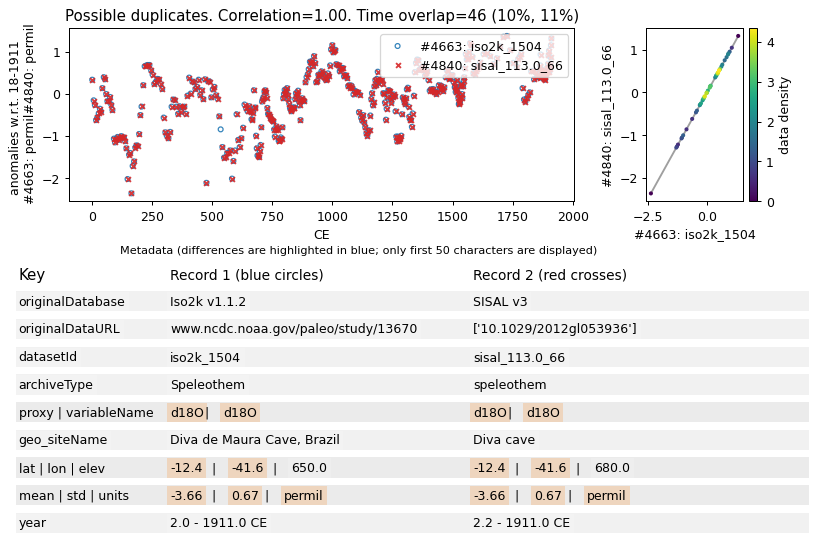

**Decision required for this duplicate pair (see figure above).**
Before inputting your decision. Would you like to leave a comment on your decision process?


 Please type your comment here and/or press enter. record 1 has originalDataURL, record 2 has correct elevation according to originalDataURL (https://www.ncdc.noaa.gov/paleo/study/13670). Keep record 2 and these notes.
Keep record 1 (iso2k_1504, blue circles) [1], record 2 (sisal_113.0_66, red crosses) [2], keep both [b], keep none [n] or create a composite of both records [c]?  [Type 1/2/b/n/c]: 2


saved figure in /home/jupyter-lluecke/dod2k_v2.0/dod2k/figs//dup_detection/all_merged/415_iso2k_1504_sisal_113.0_66__4663_4840.jpg
KEEP RED CROSSES: remove iso2k_1504, keep sisal_113.0_66.
write decision to backup file
4672 4673 277 416
> 417/429,iso2k_1554,iso2k_1556,0.0,0.9995653924115724
=== POTENTIAL DUPLICATE 416/429: iso2k_1554+iso2k_1556 ===
=== URL 1: https://www.ncdc.noaa.gov/paleo/study/1867   ===
=== URL 2: https://www.ncdc.noaa.gov/paleo/study/1867   ===
True if pot_dup_corrs[i_pot_dups]>=0.98 else False True
(len(time_1)==len(time_2)) False
metadata_identical:  True
lat True lon True elevation True archivetype True paleodata_proxy True
sites_identical:  True
URL_identical:  True
data_identical:  False
correlation_perfect:  False


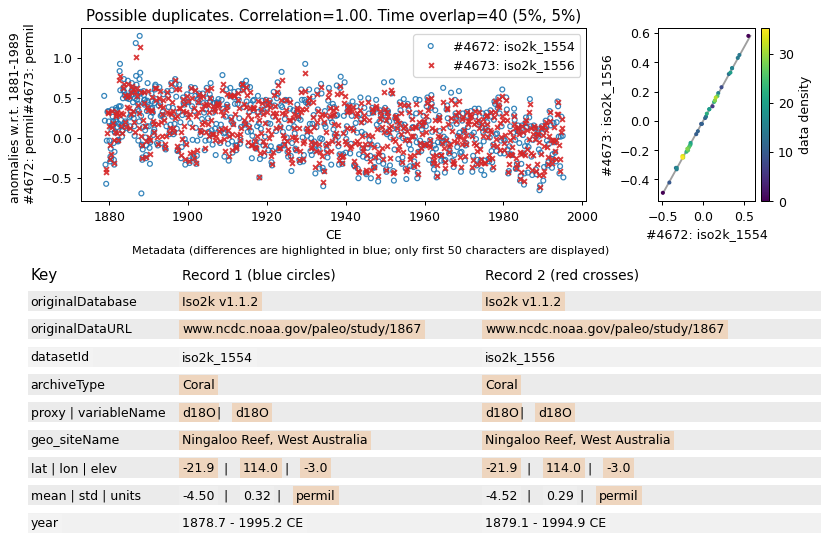

**Decision required for this duplicate pair (see figure above).**
Before inputting your decision. Would you like to leave a comment on your decision process?


 Please type your comment here and/or press enter. keep record 2 with interpolated age model consistent with originalDataURL
Keep record 1 (iso2k_1554, blue circles) [1], record 2 (iso2k_1556, red crosses) [2], keep both [b], keep none [n] or create a composite of both records [c]?  [Type 1/2/b/n/c]: 2


saved figure in /home/jupyter-lluecke/dod2k_v2.0/dod2k/figs//dup_detection/all_merged/416_iso2k_1554_iso2k_1556__4672_4673.jpg
KEEP RED CROSSES: remove iso2k_1554, keep iso2k_1556.
write decision to backup file
4705 4706 277 417
> 418/429,iso2k_1701,iso2k_1704,0.0,1.0
=== POTENTIAL DUPLICATE 417/429: iso2k_1701+iso2k_1704 ===
=== URL 1: https://www.ncdc.noaa.gov/paleo/study/1891   ===
=== URL 2: https://www.ncdc.noaa.gov/paleo/study/1891   ===
True if pot_dup_corrs[i_pot_dups]>=0.98 else False True
(len(time_1)==len(time_2)) True
metadata_identical:  True
lat True lon True elevation True archivetype True paleodata_proxy True
sites_identical:  True
URL_identical:  True
data_identical:  True
correlation_perfect:  True
RECORDS IDENTICAL (identical data). Automatically choose #1.
KEEP BLUE CIRCLES: keep iso2k_1701, remove iso2k_1704.
write decision to backup file
4737 4948 277 418
> 419/429,iso2k_1817,sisal_271.0_174,0.44453600976202207,1.0
=== POTENTIAL DUPLICATE 418/429: iso2k_1817+sisal

Type your comment on your decision process here and/or press enter: 2025/12/07 MNE: updated for PAGES2k v2.2.0, Iso2k v1.1.0, CoralHydro2k v1.0.1 all from https://lipdverse.org/ . Need to check whether the decision process removed "Palmyra2020" record in favor of Cobb et al (2003, 2013) composite records. 


(429, 27)
Saved the decisions under data/all_merged/dup_detection/dup_decisions_all_merged_MNE_25-12-07.csv
Summary of all decisions made:
#0: REMOVE record pages2k_0. KEEP record iso2k_296.
#1: REMOVE record pages2k_0. KEEP record iso2k_298.
#2: REMOVE record pages2k_0. KEEP record iso2k_299.
#3: REMOVE record pages2k_6. KEEP record FE23_northamerica_usa_az555.
#4: REMOVE record pages2k_50. KEEP record FE23_northamerica_canada_cana091.
#5: KEEP record pages2k_62. REMOVE record pages2k_63.
#6: REMOVE record pages2k_81. KEEP record ch2k_HE08LRA01_76.
#7: REMOVE record pages2k_81. KEEP record iso2k_1813.
#8: REMOVE record pages2k_83. KEEP record iso2k_1916.
#9: KEEP record pages2k_85. REMOVE record pages2k_88.
#10: REMOVE record pages2k_94. KEEP record FE23_northamerica_canada_cana153.
#11: REMOVE record pages2k_107. KEEP record FE23_northamerica_usa_ak046.
#12: KEEP record pages2k_121. REMOVE record pages2k_122.
#13: REMOVE record pages2k_132. KEEP record FE23_northamerica_canada_cana22

In [7]:
dup.duplicate_decisions(df, operator_details=operator_details, choose_recollection=True, 
                        remove_identicals=True)

In [8]:
date = str(datetime.datetime.utcnow())[2:10]
fn   = utf.find(f'dup_decisions_{df.name}_{initials}_{date}.csv', f'data/{df.name}/dup_detection')

if fn != []:
    print('----------------------------------------------------')
    print('Successfully finished the duplicate decision process!'.upper())
    print('----------------------------------------------------')
    print('Saved the decision output file in:')
    print()
    for ff in fn:
        print('%s.'%ff)
    print()
    print('You are now able to proceed with the next notebook: dup_removal.ipynb')
else:
    print('!!!!!!!!!!!!WARNING!!!!!!!!!!!')
    print('Final output file is missing.')
    print()
    print('Please re-run the notebook to complete duplicate decision process.')

----------------------------------------------------
SUCCESSFULLY FINISHED THE DUPLICATE DECISION PROCESS!
----------------------------------------------------
Saved the decision output file in:

data/all_merged/dup_detection/dup_decisions_all_merged_MNE_25-12-07.csv.

You are now able to proceed with the next notebook: dup_removal.ipynb
